<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, track our experiment runs and inspect the logs using MLflow, and apply [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model architectures, followed by explaining the model with SHAP.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- track tensorflow experiments with MLflow, access information of runs programmatically and with its tracking ui
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [75]:
# Connect colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
!pip install -q seaborn # pairplot
!pip install -q tpot  # automl

!pip install -q mlflow # tracking
!pip install -q pyngrok # workaround to run mlflow ui in colab
!pip install -q shap

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [78]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


# Task 1 - Data: Auto MPG dataset

0. Start MLflow's automatic logging using library-specific autolog calls for tensorflow: logging metrics, parameters, and models without the need for explicit log statements. 
    
    We will get into more details using **MLflow** after completing our experiment.

In [79]:
import mlflow
mlflow.tensorflow.autolog() # MLflow Autologging

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [80]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [81]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [82]:
dataset.dropna(inplace = True) # YOUR CODE HERE
print(len(dataset))

392


3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [83]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [84]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [85]:
train_dataset = dataset.sample(frac = 0.8, random_state=0) # YOUR CODE HERE
test_dataset = dataset[~dataset.index.isin(train_dataset.index)] # YOUR CODE HERE

In [86]:
print(len(train_dataset))
print(len(test_dataset))

314
78


5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

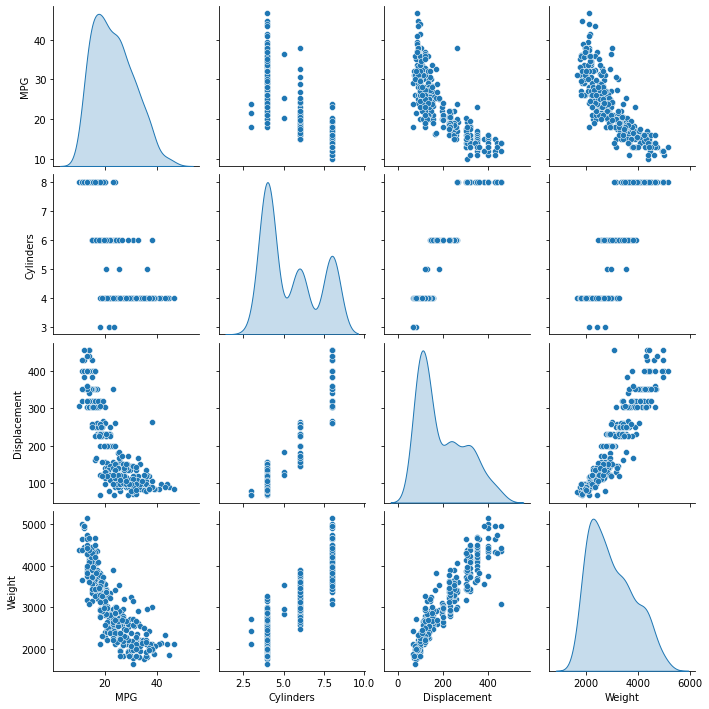

In [87]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Let's also check the overall statistics. Note how each feature covers a very different range:

In [88]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


6. Split features from labels. 
  This means, separate the target value(also called"label") from the features. 
  Label is the value that you will train the model to predict.

In [89]:
train_features = train_dataset.drop('MPG', axis=1) # YOUR CODE HERE
test_features = test_dataset.drop('MPG', axis=1)  # YOUR CODE HERE

train_labels = train_dataset['MPG'] # YOUR CODE HERE
test_labels = test_dataset['MPG'] # YOUR CODE HERE

# Task 2 - Normalization Layer

In [90]:
train_labels.head()

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [91]:
normalizer = tf.keras.layers.Normalization(axis=1) # YOUR CODE HERE

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [92]:
normalizer.adapt(np.array(train_features)) # YOUR CODE HERE

We can see the feature mean and variance are stored in the layer:

In [93]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

feature variance: [     2.88   10850.413   1446.699 709896.9        7.755     13.467
      0.147      0.158      0.235]


When the layer is called, it returns the input data, with each feature independently normalized:

In [94]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Task 3 - Linear Regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this earlier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce one output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [95]:
linear_model = tf.keras.Sequential([
    normalizer,# YOUR CODE HERE
    layers.Dense(units=1)# YOUR CODE HERE
])

In [96]:
train_features.shape

(314, 9)

In [97]:
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [98]:
linear_model.predict(train_features[:10])

array([[-1.441],
       [-1.338],
       [ 0.438],
       [-3.101],
       [ 1.003],
       [-1.089],
       [ 1.055],
       [ 1.046],
       [-0.573],
       [ 2.974]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [99]:
linear_model.layers[1].kernel

<tf.Variable 'dense_4/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.42 ],
       [ 0.648],
       [ 0.611],
       [-0.1  ],
       [ 0.675],
       [-0.738],
       [ 0.158],
       [ 0.583],
       [-0.691]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [100]:
linear_model.compile(
    tf.keras.optimizers.Adam(name='adam',learning_rate=0.1), # YOUR CODE HERE
    loss='mean_absolute_error' # YOUR CODE HERE
    )

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [101]:
%%time
history = linear_model.fit(train_features, train_labels, epochs=100, verbose = 0, validation_split=0.2) # YOUR CODE HERE

2022/10/02 02:22:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc193541a45941f18c57b88b807f858c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/10/02 02:22:10 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/10/02 02:22:20 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To 

CPU times: user 6.37 s, sys: 295 ms, total: 6.67 s
Wall time: 18.9 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [102]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.497756,2.485837,95
96,2.465359,2.532995,96
97,2.477890,2.461969,97
98,2.472761,2.480911,98
99,2.488535,2.478597,99


In [103]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

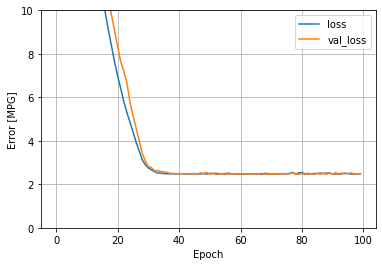

In [104]:
plot_loss(history)# YOUR CODE HERE

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [105]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(test_features, test_labels) # YOUR CODE HERE

3/3 [==============================] - 0s 7ms/step - loss: 2.4720


In [106]:
test_results

{'linear_model': 2.471980333328247}

# Task 4 - Regression with a Deep Neural Network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [107]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [108]:
dnn_model = build_and_compile_model(normalizer) # YOUR CODE HERE

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [109]:
dnn_model.summary() # YOUR CODE HERE

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [110]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2022/10/02 02:22:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6d1ff68a27654a4f810a2f0a89219f21', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/10/02 02:22:34 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/10/02 02:22:40 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To 

CPU times: user 8.78 s, sys: 427 ms, total: 9.2 s
Wall time: 19.1 s


5. Visualize the model's training progress using the stats stored in the history object. 

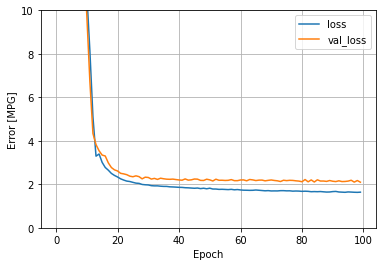

In [111]:
plot_loss(history)

Do you think the DNN model is overfitting? What gives away? 

The model is not overfitting as the training loss is pretty steep at the beginnig and increasing the epoch (more training examples) does not decrease the validation loss further and is pretty flat. 

6. Let's save the results for later comparison.

In [112]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5 - Make Predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [113]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.471980
dnn_model,1.694112


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

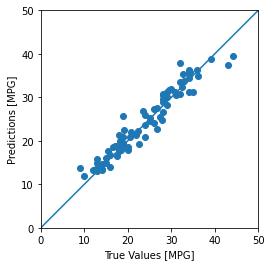

In [114]:
test_predictions = dnn_model.predict(test_features).flatten() # YOUR CODE HERE

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

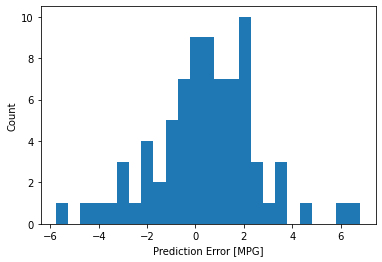

In [115]:
error = test_predictions - test_labels # YOUR CODE HERE
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [116]:
dnn_model.save('dnn_model')

5. Reload the model with `Model.load_model`; it gives identical output:

In [117]:
reloaded = tf.keras.models.load_model('dnn_model') # YOUR CODE HERE

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [118]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.471980
dnn_model,1.694112
reloaded,1.694112


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Since there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [119]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

In [120]:
train_features.shape
fake.shape
fake

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,4.0,0.000000,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
1,4.0,1.597444,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
2,4.0,3.194888,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
3,4.0,4.792332,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
4,4.0,6.389776,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
309,4.0,493.610224,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
310,4.0,495.207668,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
311,4.0,496.805112,94.5,2822.5,15.5,76.0,0.0,0.0,1.0
312,4.0,498.402556,94.5,2822.5,15.5,76.0,0.0,0.0,1.0


2. Create a plotting function to:

    a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot 
    
    b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [121]:
def plot_displacement(x, y):
    plt.scatter(train_features['Displacement'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Displacement')
    plt.ylabel('MPG')
    plt.legend()

3. Visualize predicted MPG using the linear model.

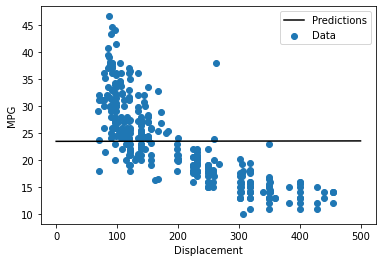

In [122]:
plot_displacement(fake.Displacement, linear_model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

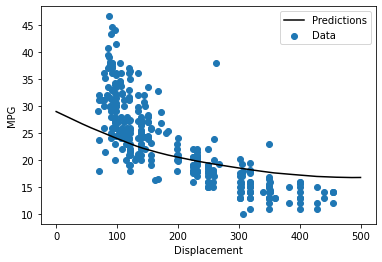

In [123]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
  Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?

In [124]:
early stopping & dropout

SyntaxError: ignored

# Task 7 - MLflow Tracking

In this task, we briefly explore [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html#tracking), one of four primary functions that MLflow offers for managing the end-to-end machine learning lifecycle. We will access the information runs programmatically in python and then set up the MLflow UI for easy interaction.

1. Experiments.

    MLflow Tracking is organized around the concept of `runs`, which are executions of some piece of modeling code; and runs are organized into experiments. 

    We set the auto logging in the beginning, we can verify that
    - there is one experiment
    - its name is `0`
    - all of its artifacts are stored at `file:///content/mlruns/0` in Google Drive.

In [125]:
from mlflow import MlflowClient
client = MlflowClient()
client.list_experiments() 

``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.


[<Experiment: artifact_location='file:///content/mlruns/0', creation_time=1664674716724, experiment_id='0', last_update_time=1664674716724, lifecycle_stage='active', name='Default', tags={}>]

2. Runs. 

   List information for runs that are under experiment '0' using [`mlflow.list_run_infos()`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.list_run_infos).

In [126]:
mlflow.search_runs("0") # YOUR CODE HERE

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.loss,metrics.val_loss,params.validation_split,params.shuffle,...,params.opt_epsilon,params.steps_per_epoch,params.sample_weight,params.workers,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.autologging,tags.mlflow.user,tags.mlflow.log-model.history
0,6d1ff68a27654a4f810a2f0a89219f21,0,FINISHED,file:///content/mlruns/0/6d1ff68a27654a4f810a2...,2022-10-02 02:22:21.931000+00:00,2022-10-02 02:22:41.045000+00:00,1.638507,2.097056,0.2,True,...,1e-07,None,None,1,LOCAL,/usr/local/lib/python3.7/dist-packages/ipykern...,amazing-smelt-206,tensorflow,root,"[{""run_id"": ""6d1ff68a27654a4f810a2f0a89219f21""..."
1,fc193541a45941f18c57b88b807f858c,0,FINISHED,file:///content/mlruns/0/fc193541a45941f18c57b...,2022-10-02 02:22:01.734000+00:00,2022-10-02 02:22:20.662000+00:00,2.488535,2.478597,0.2,True,...,1e-07,None,None,1,LOCAL,/usr/local/lib/python3.7/dist-packages/ipykern...,capable-grouse-803,tensorflow,root,"[{""run_id"": ""fc193541a45941f18c57b88b807f858c""..."
2,ed39e7fbdf9f45e4acebed0d99107068,0,FINISHED,file:///content/mlruns/0/ed39e7fbdf9f45e4acebe...,2022-10-02 01:39:02.709000+00:00,2022-10-02 01:39:13.838000+00:00,1.609217,2.267189,0.2,True,...,1e-07,None,None,1,LOCAL,/usr/local/lib/python3.7/dist-packages/ipykern...,fearless-skunk-846,tensorflow,root,"[{""run_id"": ""ed39e7fbdf9f45e4acebed0d99107068""..."
3,fed4a2d32a954d2c8614c5f48abc8a63,0,FINISHED,file:///content/mlruns/0/fed4a2d32a954d2c8614c...,2022-10-02 01:38:36.819000+00:00,2022-10-02 01:39:02.214000+00:00,2.468866,2.521055,0.2,True,...,1e-07,None,None,1,LOCAL,/usr/local/lib/python3.7/dist-packages/ipykern...,useful-cow-140,tensorflow,root,"[{""run_id"": ""fed4a2d32a954d2c8614c5f48abc8a63""..."


3. Retrieve the currently active run, i.e., the DNN model. Hint: `mlflow.last_active_run()` 

In [127]:
autolog_run = mlflow.last_active_run() # YOUR CODE HERE

4. Use function `print_auto_logged_info` provided below to fetch the auto logged parameters and metrics for `autolog_run`. 

In [128]:
import json
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(json.dumps(r.data.params, indent=4)))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [129]:
print_auto_logged_info(
    autolog_run# YOUR CODE HERE
    ) 

run_id: 6d1ff68a27654a4f810a2f0a89219f21
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {
    "opt_decay": "0.0",
    "validation_split": "0.2",
    "max_queue_size": "10",
    "opt_epsilon": "1e-07",
    "workers": "1",
    "opt_beta_2": "0.999",
    "sample_weight": "None",
    "class_weight": "None",
    "initial_epoch": "0",
    "opt_amsgrad": "False",
    "shuffle": "True",
    "opt_name": "Adam",
    "validation_steps": "None",
    "steps_per_epoch": "None",
    "opt_learning_rate": "0.001",
    "epochs": "100",
    "validation_freq": "1",
    "batch_size": "None",
    "validation_batch_size": "None",
    "opt_beta_1": "0.9",
    "use_multiprocessing": "False"
}
metrics: {'val_loss': 2.0970561504364014, 'loss': 1.6385067701339722}
tags: {}


5. Optional. Retrieve the best run using [MlflowClient().search_runs()](https://www.mlflow.org/docs/latest/search-runs.html#python).

In [130]:
runs = MlflowClient().search_runs(
    experiment_ids = "0",
  max_results=1,
  order_by=["metrics.accuracy DESC"]
)[0] # YOUR CODE HERE

In [131]:
runs

<Run: data=<RunData: metrics={'loss': 1.6385067701339722, 'val_loss': 2.0970561504364014}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "6d1ff68a27654a4f810a2f0a89219f21", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-10-02 02:22:33.283857", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                          

6. To see what's logged in the file system `/content/mlruns/`, click tab `files` in the left sidepanel in Colab. For example, 
    ```
    mlruns
    └── 0
        ├── 3a5aebdd35ef46fb8dc35b40e542f0a4
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        ├── c627bc526c4a4c418a8285627e61a16d
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        └── meta.yaml

    11 directories, 3 files
    ```

    Inspect the model summary of the DNN model you ran previously; it is located at `artifacts/model_summary.txt` of the corresponding run. Use `cat $filepath`. 

In [132]:
!cat mlruns/0/44010366403a426aa298e17797342e3c/artifacts/model_summary.txt # YOUR CODE HERE (bash)

cat: mlruns/0/44010366403a426aa298e17797342e3c/artifacts/model_summary.txt: No such file or directory


7. Tracking UI. 

    MLflow provides an UI for us to visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools. 

    If your runs are logged to a local mlruns directory, run `mlflow ui` in the directory above it will load the corresponding runs. 
    
    Running localhost server in Colab, however, requires a bit of extra work:
    - set up a free account on [ngrok](https://dashboard.ngrok.com/get-started/setup)
    - retrieve the authtoken from https://dashboard.ngrok.com/auth and update the code cell below
    
   **NOTE**. NEVER share your secrets. Best to keep `NGROK_AUTH_TOKEN` as an environment variable and retrieve it via `os.environ.get("NGROK_AUTH_TOKEN")`.

In [133]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") 

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (see Note above)
NGROK_AUTH_TOKEN = "2FVsCwBdXKyj4nZ9zjzSjItSarx_4wXs36RypUYQPEUJagiG3"  # YOUR CODE HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://86b7-34-125-46-254.ngrok.io


8. Interact with Tracking UI. 

    Open the link, output from the previous cell. get oriented, `Parameters`, `Metrics`, `Artifacts`, and so on.
    
    When you are done, make sure to terminate the open tunnel:

In [134]:
ngrok.kill()

# Task 8 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

  The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

  `generations`: 10

  `population_size`: 40

  `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

  `verbosity`: 2 (so you can see each generation's performance)

  The final line with create a Python script tpot_products_pipeline.py with the code to create the optimal model found by TPOT.

In [135]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_absolute_error', # YOUR CODE HERE
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.0391493673159626

Generation 2 - Current best internal CV score: -2.0391493673159626

Generation 3 - Current best internal CV score: -2.0391493673159626

Generation 4 - Current best internal CV score: -2.0391493673159626

Generation 5 - Current best internal CV score: -1.9760831555452802

Generation 6 - Current best internal CV score: -1.9399572887864829

Generation 7 - Current best internal CV score: -1.9399572887864829

Generation 8 - Current best internal CV score: -1.9399572887864829

Generation 9 - Current best internal CV score: -1.9399572887864829

Generation 10 - Current best internal CV score: -1.9227892515787672

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
Tpop score on test data: -1.68
CPU times: user 7min 23s, sys: 18.9 s, total: 7min 42s
Wall time: 7min 29s


2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [136]:
!cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -1.9227892515787672
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


3. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. 
Save the predictions as `y_pred`, and compute appropriate evaluation metric. 
You may find that for this simple data set, the neural network we built outperforms the tree-based model, yet note it is not a conclusion that we can generalize for all tabular data. 

In [137]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=42)
exported_pipeline.fit(train_features, train_labels)
y_pred = exported_pipeline.predict(test_features)

test_results['TPOT'] = cross_val_score(exported_pipeline,test_features ,test_labels,cv=10)
test_results

{'linear_model': 2.471980333328247,
 'dnn_model': 1.694111943244934,
 'reloaded': 1.694111943244934,
 'TPOT': array([ 0.707,  0.812,  0.629,  0.896,  0.265,  0.911,  0.842,  0.839,
         0.777, -0.734])}

In [139]:
import shap
# YOUR CODE GOES HERE!
explainer = shap.KernelExplainer(dnn_model, test_features)
shap_values = explainer.shap_values(test_features.iloc[2,:], nsamples=50)

shap.force_plot(explainer.expected_value, shap_values[0], test_features.iloc[2,:])


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [150]:
#pd.DataFrame(shap_values).to_csv('shap_values.csv',index=False)
shap_values[0]


Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

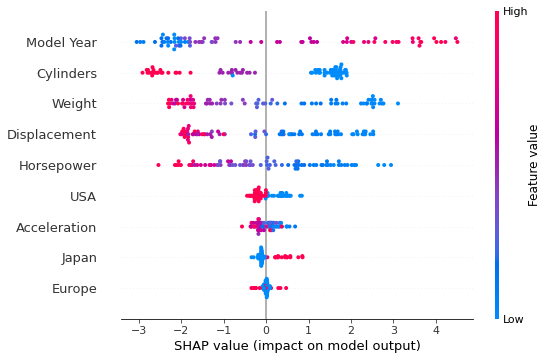

In [153]:

explainer = shap.TreeExplainer(exported_pipeline, test_features)
shap_values = explainer.shap_values(test_features)
shap.summary_plot(shap_values, test_features)




In [154]:
shap_values

array([[-2.686, -1.728, -2.061, -1.753,  0.48 , -1.839,  0.017, -0.11 ,
        -0.239],
       [-2.913, -1.911, -2.538, -2.286, -0.051, -2.157,  0.017, -0.112,
        -0.268],
       [-2.618, -1.992, -2.148, -2.312, -0.012, -2.316,  0.015, -0.11 ,
        -0.288],
       [ 1.524,  0.665, -0.614,  1.078,  0.223, -2.432, -0.014,  0.229,
         0.318],
       [-0.677, -1.387, -0.371, -0.02 ,  0.373, -2.165, -0.009, -0.133,
        -0.142],
       [-2.75 , -1.88 , -1.811, -2.077,  0.353, -2.166,  0.016, -0.113,
        -0.255],
       [-2.573, -1.816, -1.622, -1.876,  0.047, -2.005,  0.016, -0.111,
        -0.242],
       [-2.784, -1.978, -1.719, -2.291,  0.271, -2.157,  0.016, -0.114,
        -0.256],
       [-0.61 , -1.459,  0.223, -1.054,  0.245, -2.055, -0.008, -0.107,
        -0.265],
       [ 1.756,  2.141,  1.714,  2.516, -0.168, -2.308,  0.043,  0.76 ,
         0.581],
       [ 1.604,  1.624,  0.716,  1.888, -0.123, -2.966, -0.   , -0.135,
        -0.118],
       [-0.787,  0.54

# Task 10 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  [Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

In [146]:
train_dataset.to_csv('train_dataset.csv', index=False)
pd.DataFrame([test_results]).to_csv('results.csv', index = False)

In [147]:
#test_results.pop('TPOT')
test_results

{'linear_model': 2.471980333328247,
 'dnn_model': 1.694111943244934,
 'reloaded': 1.694111943244934,
 'TPOT': array([ 0.707,  0.812,  0.629,  0.896,  0.265,  0.911,  0.842,  0.839,
         0.777, -0.734])}

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.